In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import matplotlib.dates as mdates
import string

In [2]:
import matplotlib as mpl

FONT_SIZE = 16
AXES_SIZE = FONT_SIZE * 1.5
TICK_SIZE = FONT_SIZE * 1.25
LEGEND_SIZE = FONT_SIZE

my_rcParams = {
    "axes.spines.top": False,
    "axes.spines.right": False,
    "lines.linewidth": 5,
    "font.size": FONT_SIZE,
    "font.family": "Helvetica",
    "axes.titlesize": AXES_SIZE,
    "axes.labelsize": AXES_SIZE,
    "xtick.labelsize": TICK_SIZE,
    "ytick.labelsize": TICK_SIZE,
    "legend.fontsize": LEGEND_SIZE,
    "xtick.major.pad": FONT_SIZE / 2,
    "ytick.major.pad": FONT_SIZE / 2,
}

for k, v in my_rcParams.items():
    mpl.rcParams[k] = v

In [3]:
errors = pd.read_csv("../errors/real_time_nextclade/model_scores.tsv", sep="\t")
pivot_dates = np.sort(errors.pivot_date.unique())

In [4]:
errors.head()

location model  pivot_date  lead variant       MAE      RMSE    loglik  \
0      USA   MLR  2022-09-15   -73   Delta  0.000016  0.000016 -0.056235   
1      USA   MLR  2022-09-15   -72   Delta  0.000017  0.000017 -0.222553   
2      USA   MLR  2022-09-15   -71   Delta  0.000018  0.000018 -1.980808   
3      USA   MLR  2022-09-15   -70   Delta  0.000019  0.000019 -2.128466   
4      USA   MLR  2022-09-15   -69   Delta  0.000020  0.000020 -0.126000   

   coverage  total_seq  raw_freq  smoothed_freq  pred_freq        date  \
0       1.0     2579.0  0.000000       0.000038   0.000022  2022-07-04   
1       1.0    10624.0  0.000000       0.000038   0.000021  2022-07-05   
2       1.0     8078.0  0.000124       0.000038   0.000020  2022-07-06   
3       1.0     7102.0  0.000141       0.000038   0.000019  2022-07-07   
4       1.0     6895.0  0.000000       0.000038   0.000018  2022-07-08   

     ci_low   ci_high nextclade_version  
0  0.000011  0.000045     retrospective  
1  0.000010  0.000043     retrospective  
2  0.000010  0.000041     retrospective  
3  0.000009  0.000040     retrospective  
4  0.000008  0.000038     retrospective

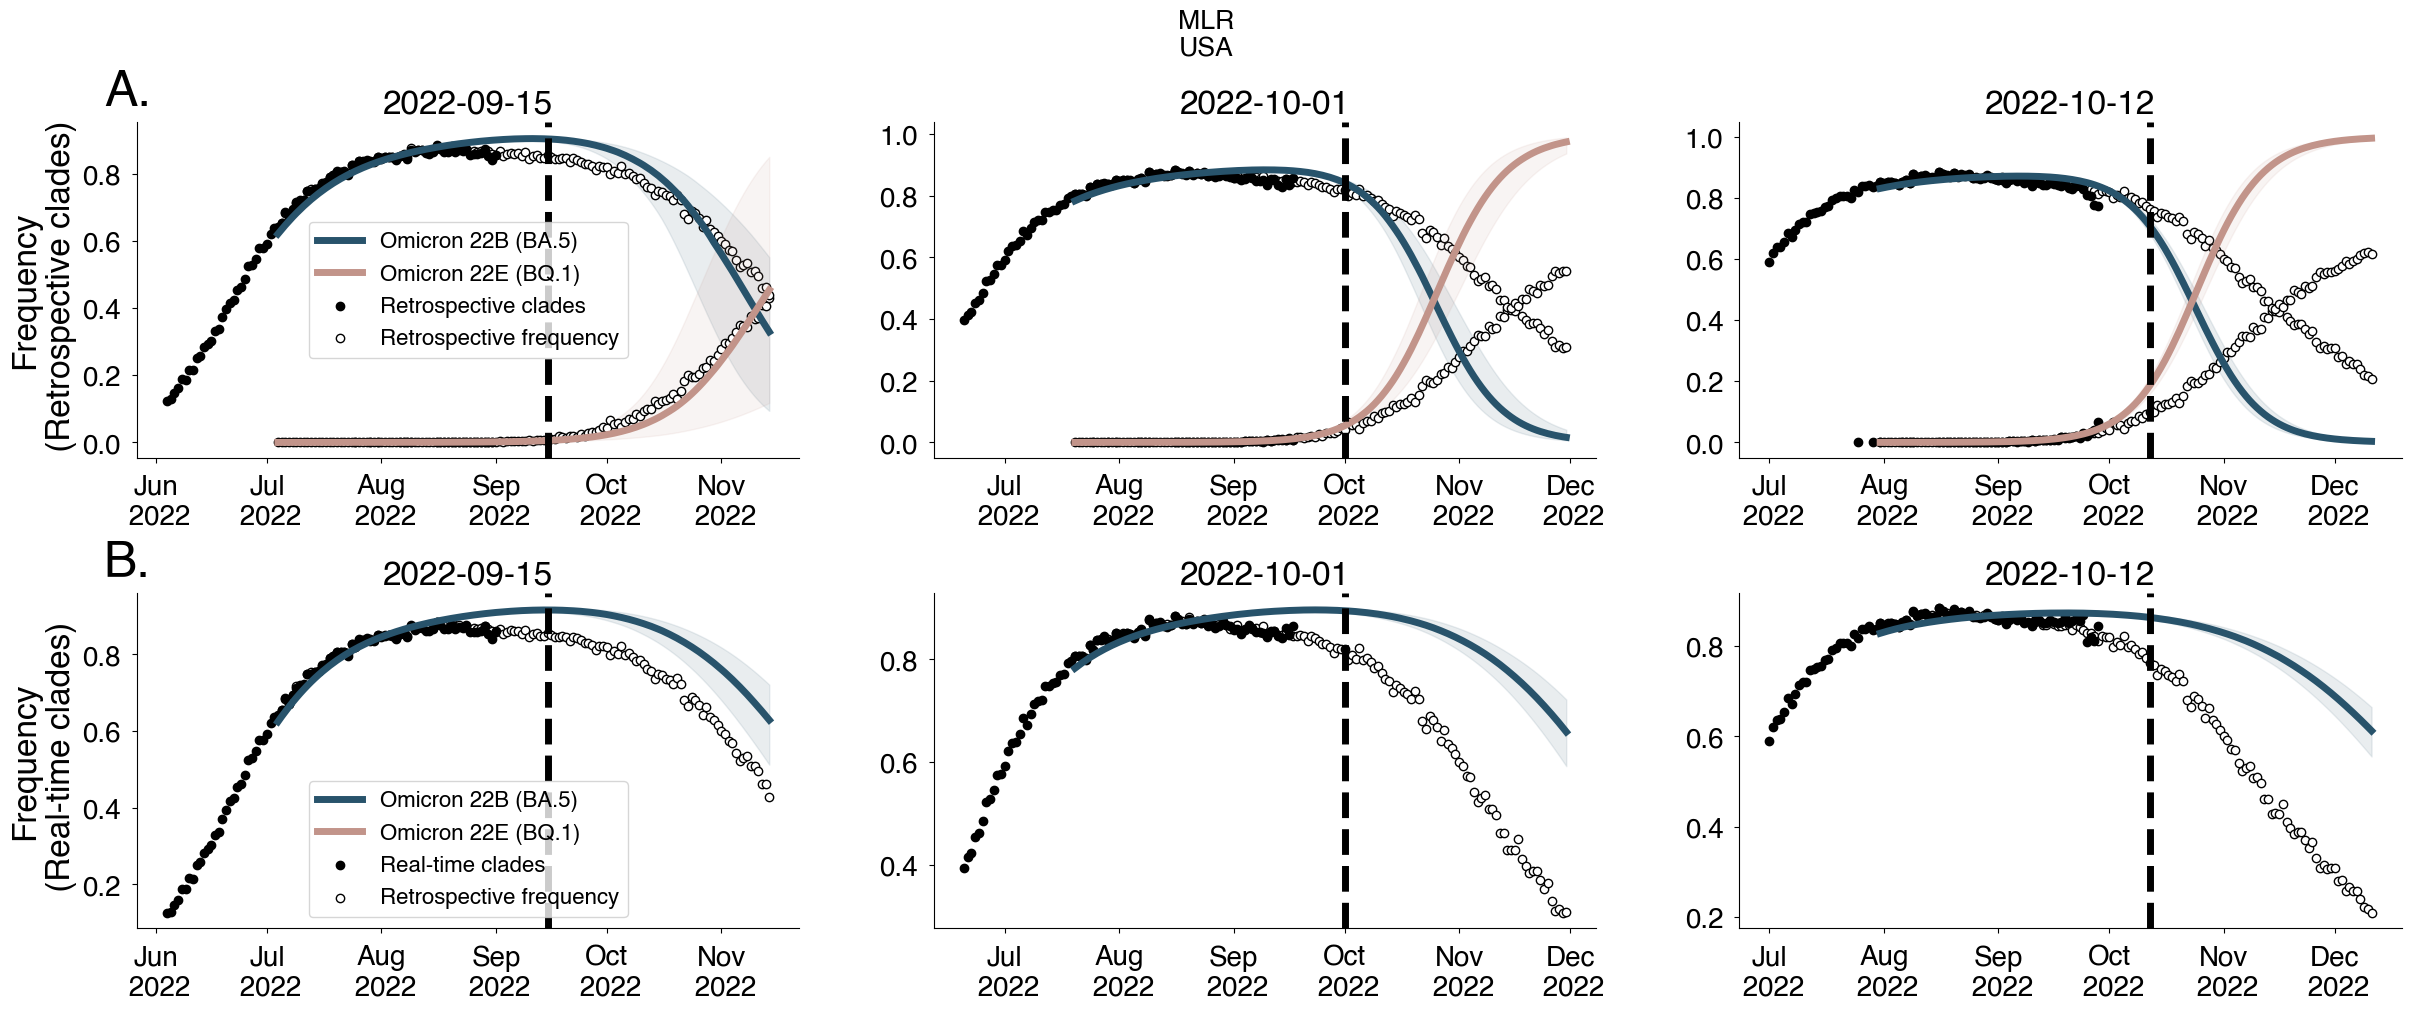

In [13]:
import matplotlib.dates as mdates

NC_VERSION_TO_DATASET = {"retrospective": "", "real_time": "_past"}
NC_VERSION_TO_LABEL = {"retrospective": "Retrospective clades", "real_time": "Real-time clades"}
VARIANT_LABELS = {"Omicron 22B": "Omicron 22B (BA.5)", "Omicron 22E": "Omicron 22E (BQ.1)",}

def sorted_legend(ax, key=None):
    if key is None:
        key = lambda t: t[0]
    handles, labels = ax.get_legend_handles_labels()
    labels, handles = zip(*sorted(zip(labels, handles), key=key))
    ax.legend(handles, labels)

def prep_training_data(pivot, location, variant, nextclade_version):
    dataset = NC_VERSION_TO_DATASET[nextclade_version]
    this_data = pd.read_csv(f"../data/real_time_nextclade/{pivot}/seq_counts_{pivot}{dataset}.tsv", sep="\t")
    this_data = this_data[this_data["location"] == location]
    total_sequences = this_data.groupby(["date", "location"])["sequences"].sum()
    total_sequences.name = "total_sequences"
    this_data = this_data[this_data["variant"] == variant]
    this_data = this_data.merge(total_sequences, on=["date", "location"])
    return this_data

location = "USA"
variants = ["Omicron 22B", "Omicron 22E"]
model = "MLR"

COLOR = ["#28536B", "#C2948A"]

def make_nextclade_comparison_plot(variants, location, model):
    fig = plt.figure(figsize=(24., 10.), constrained_layout=True)
    spec = fig.add_gridspec(ncols=3, nrows=2, wspace=0.1)

    axes_to_label = []
    for n, nextclade_version in enumerate(["retrospective", "real_time"]):
        for p, pivot in enumerate(pivot_dates):
            ax = fig.add_subplot(spec[n, p])
            for v, variant in enumerate(variants):
                _errors = errors[errors["model"] == model]
                _error = _errors[_errors["pivot_date"] == pivot]
                _error = _error[_error["variant"] == variant]
                _error = _error[_error["location"] == location]
                _error = _error[_error["nextclade_version"] == nextclade_version]

                this_data = prep_training_data(pivot, location, variant, nextclade_version)

                # Plot prediction
                ax.plot(pd.to_datetime(_error.date), _error.pred_freq, color=COLOR[v], label=VARIANT_LABELS[variant])
                ax.fill_between(pd.to_datetime(_error.date), _error.ci_low, _error.ci_high, color=COLOR[v], alpha=0.1)

                # Plot retrospective data
                retrosepective_label = "Retrospective frequency"
                ax.scatter(pd.to_datetime(_error.date), _error.raw_freq, color="w", ec='k', label=retrosepective_label if v == 0 else "")

                # Plot oberved frequency
                observed_label = NC_VERSION_TO_LABEL[nextclade_version]
                ax.scatter(pd.to_datetime(this_data.date), 
                           this_data["sequences"] / this_data["total_sequences"], 
                           color="k", 
                           ec='k', 
                           label=observed_label if v == 0 else "")

            # Pivot date
            ax.axvline(x=pd.to_datetime(pivot), color="k", linestyle="--")
            ax.set_title(pivot)
            ax.xaxis.set_major_formatter(mdates.DateFormatter('%b\n %Y'))
            if p == 0:
                ax.set_ylabel(f"Frequency\n ({NC_VERSION_TO_LABEL[nextclade_version]})" )
                sorted_legend(ax, key=lambda t: "A" if t[0] in variants else t[0])
                axes_to_label.append(ax)
                
    ax_labels = [s + "." for s in string.ascii_uppercase]
    for ax, ax_label in zip(axes_to_label, ax_labels):
        ax.text(-0.05, 1.05, ax_label, transform=ax.transAxes, size=36, weight='bold')
    
    fig.suptitle(model + "\n" + location)
    return fig

fig = make_nextclade_comparison_plot(variants, location, model)

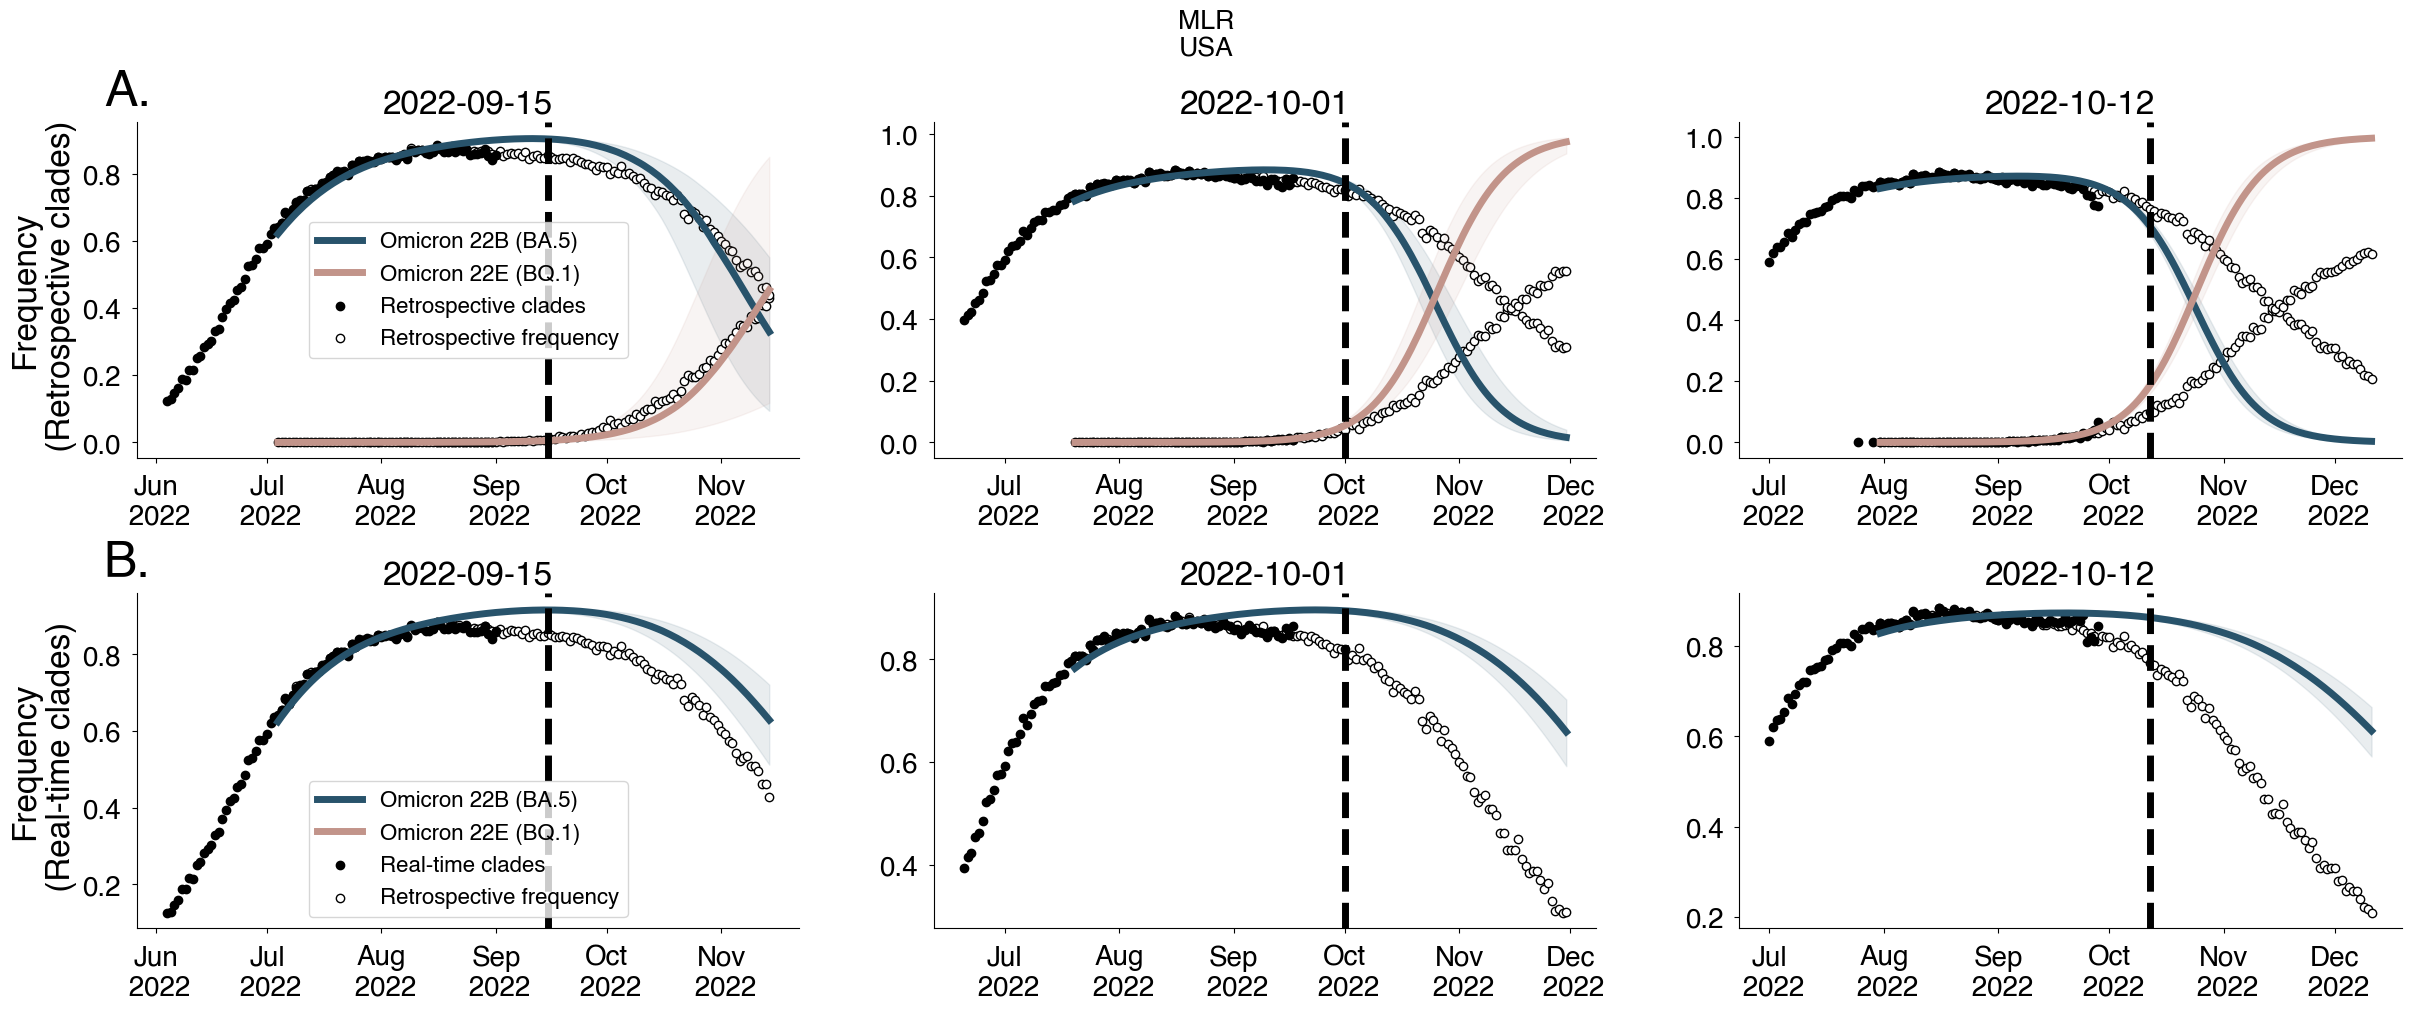

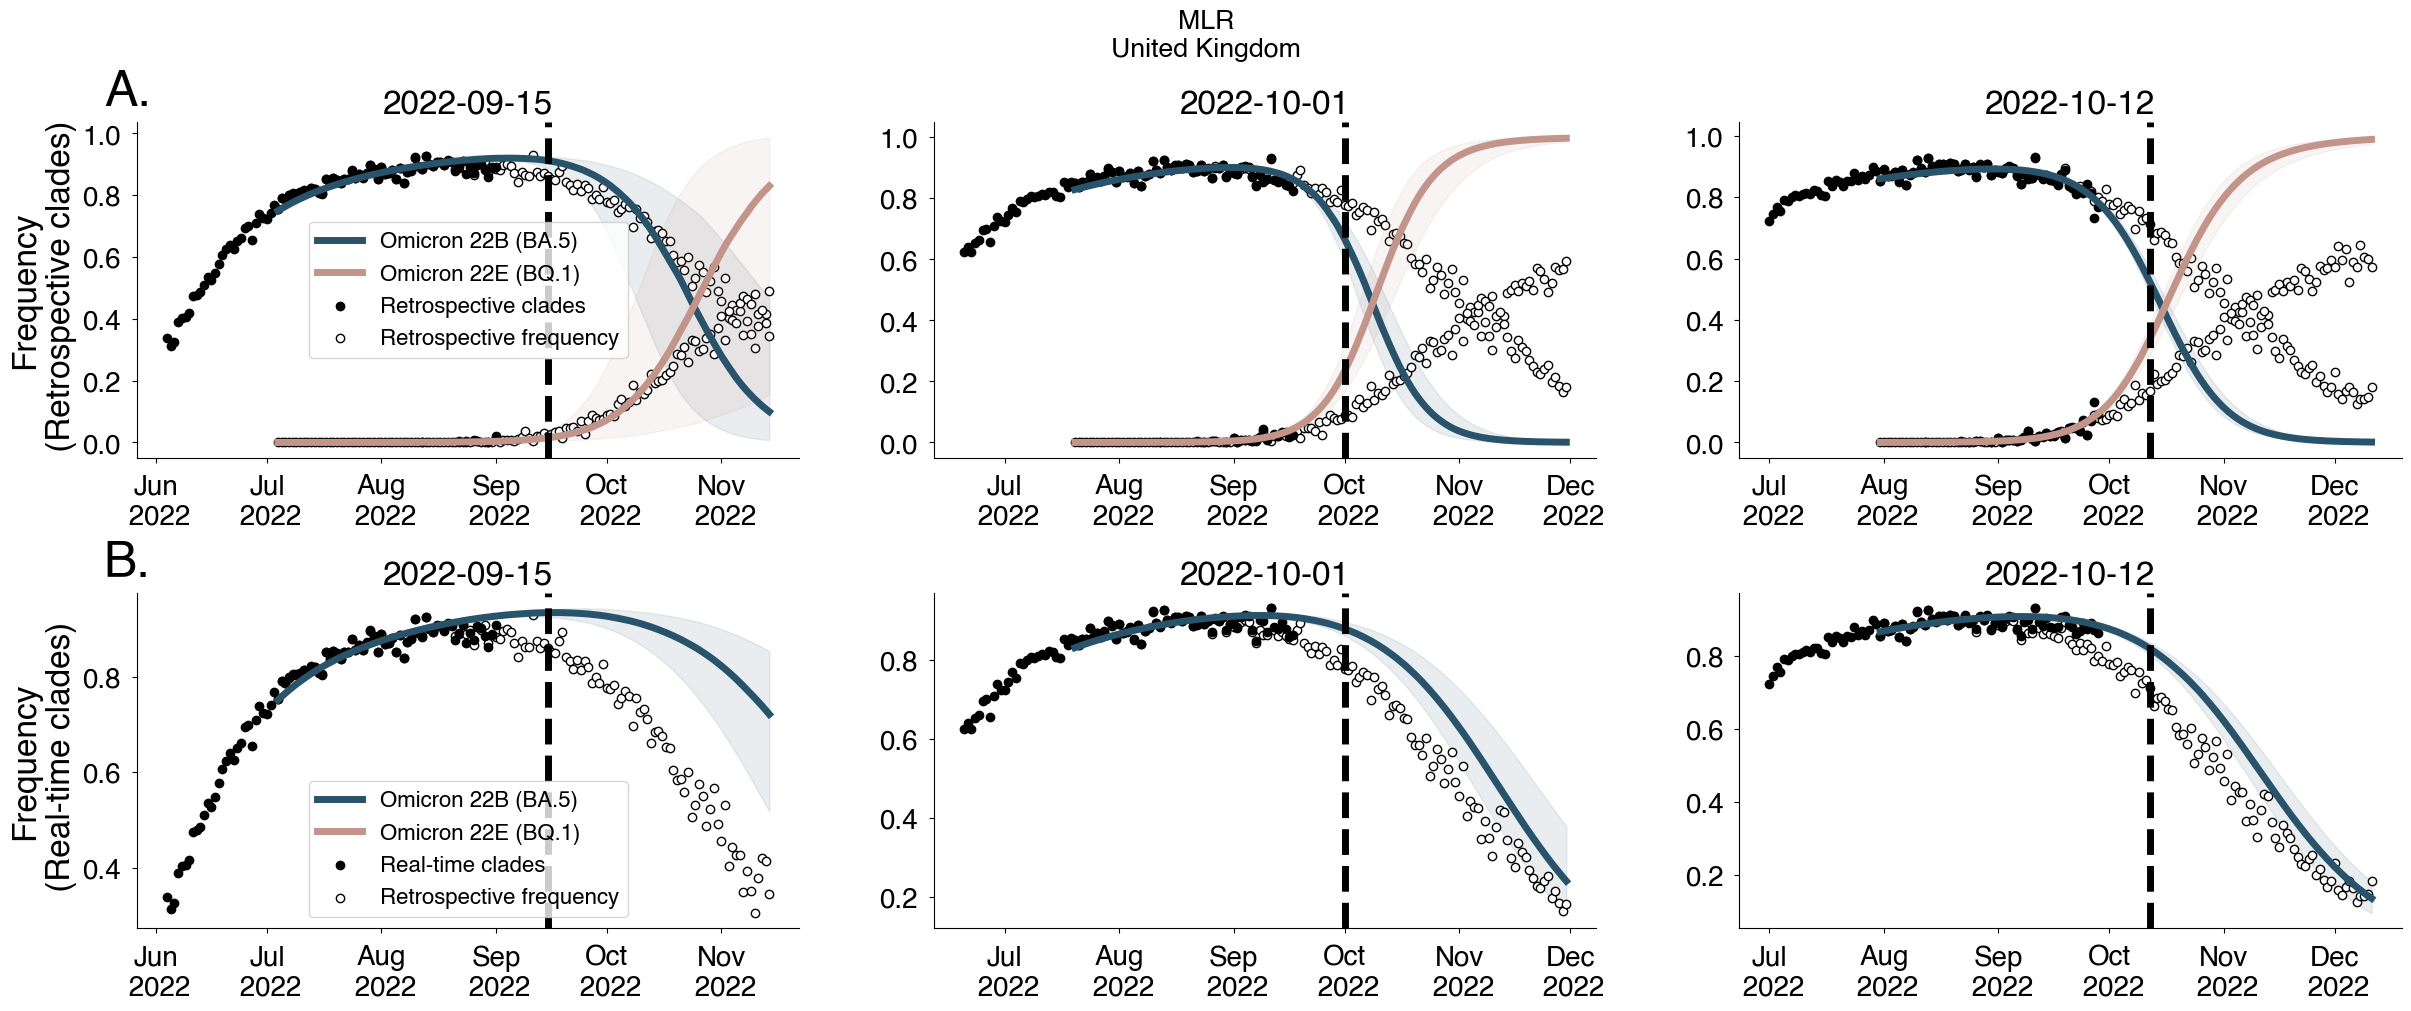

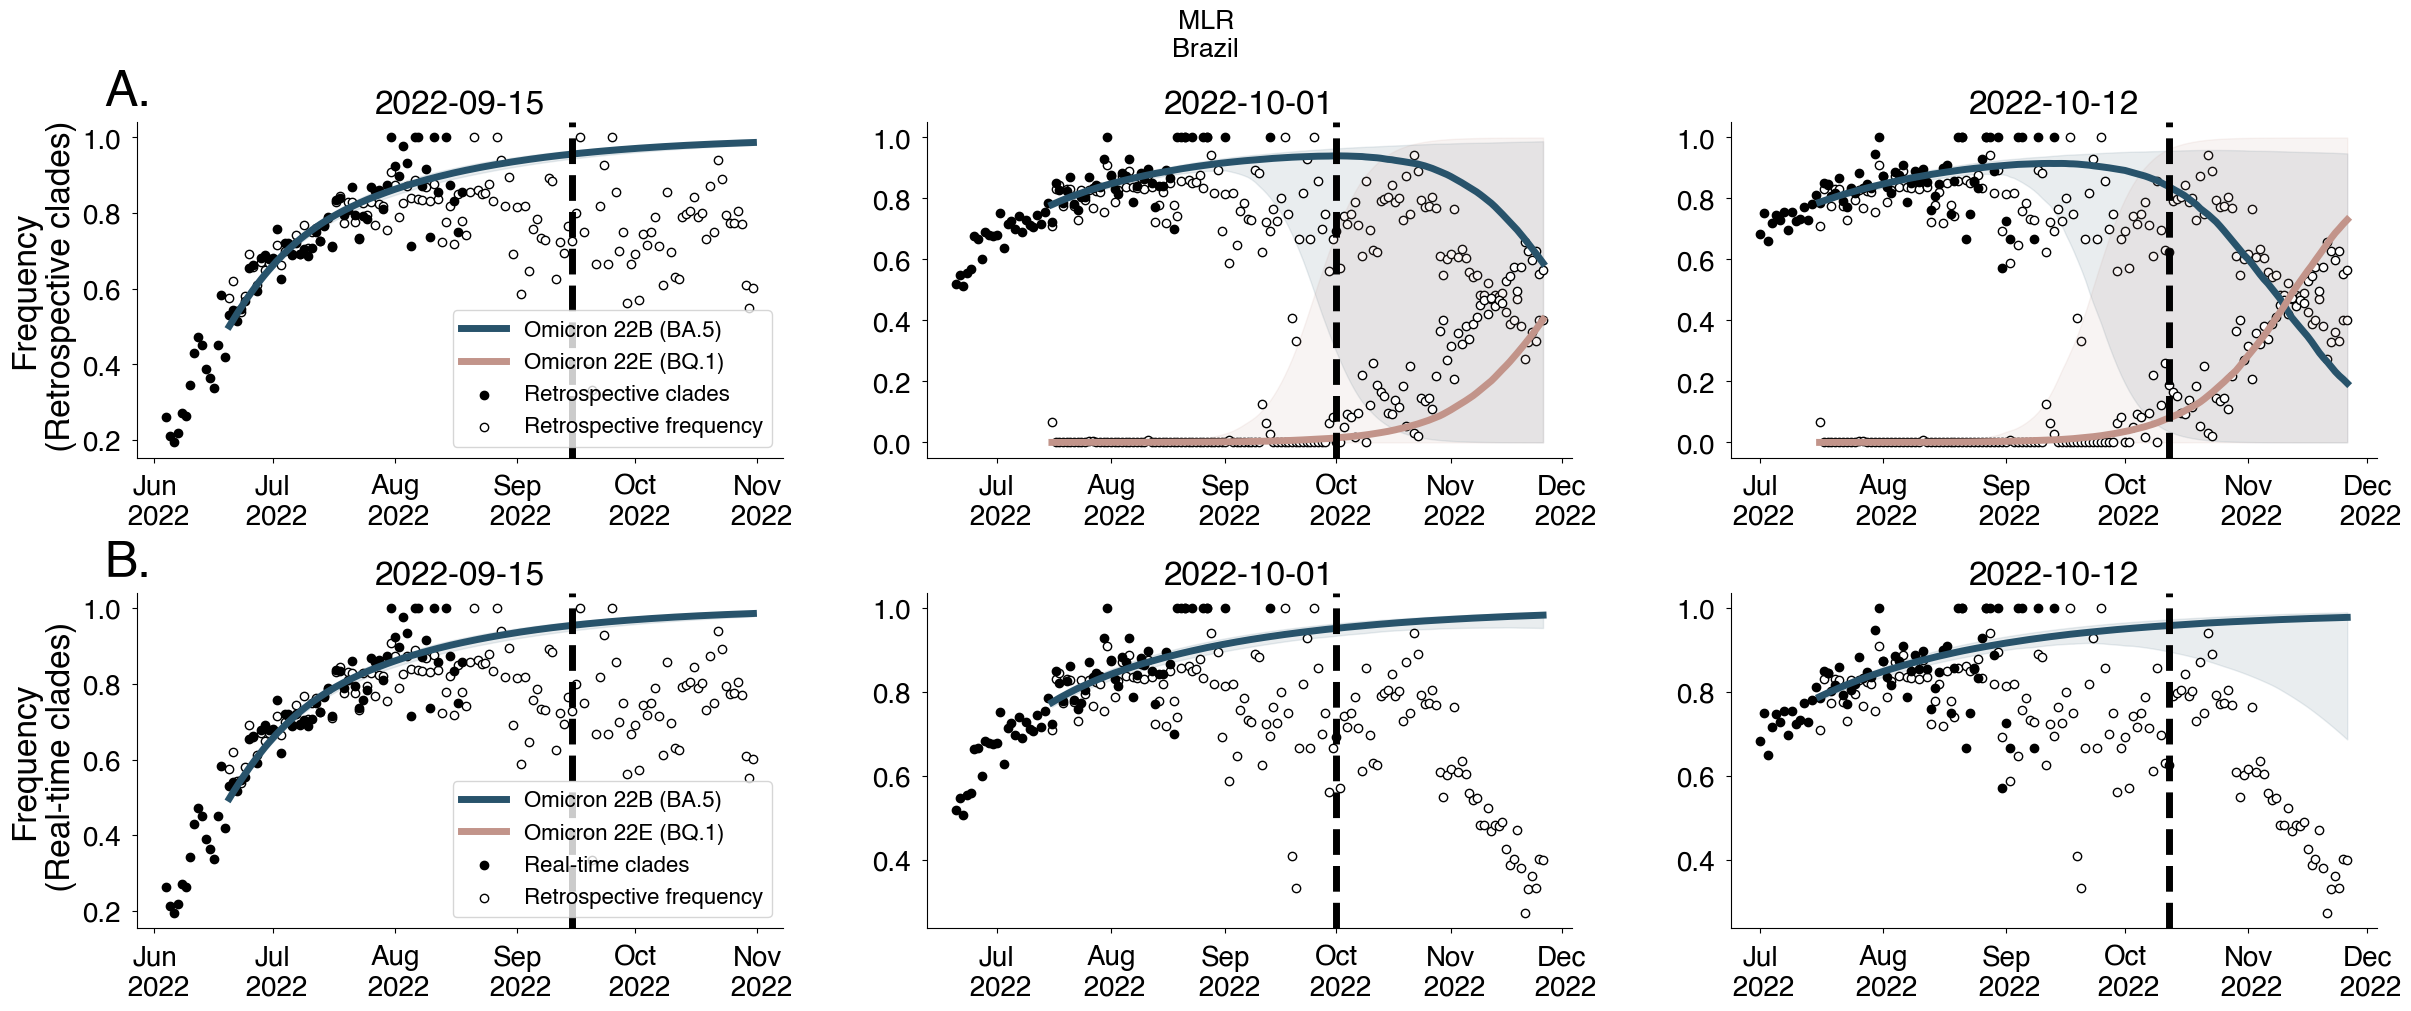

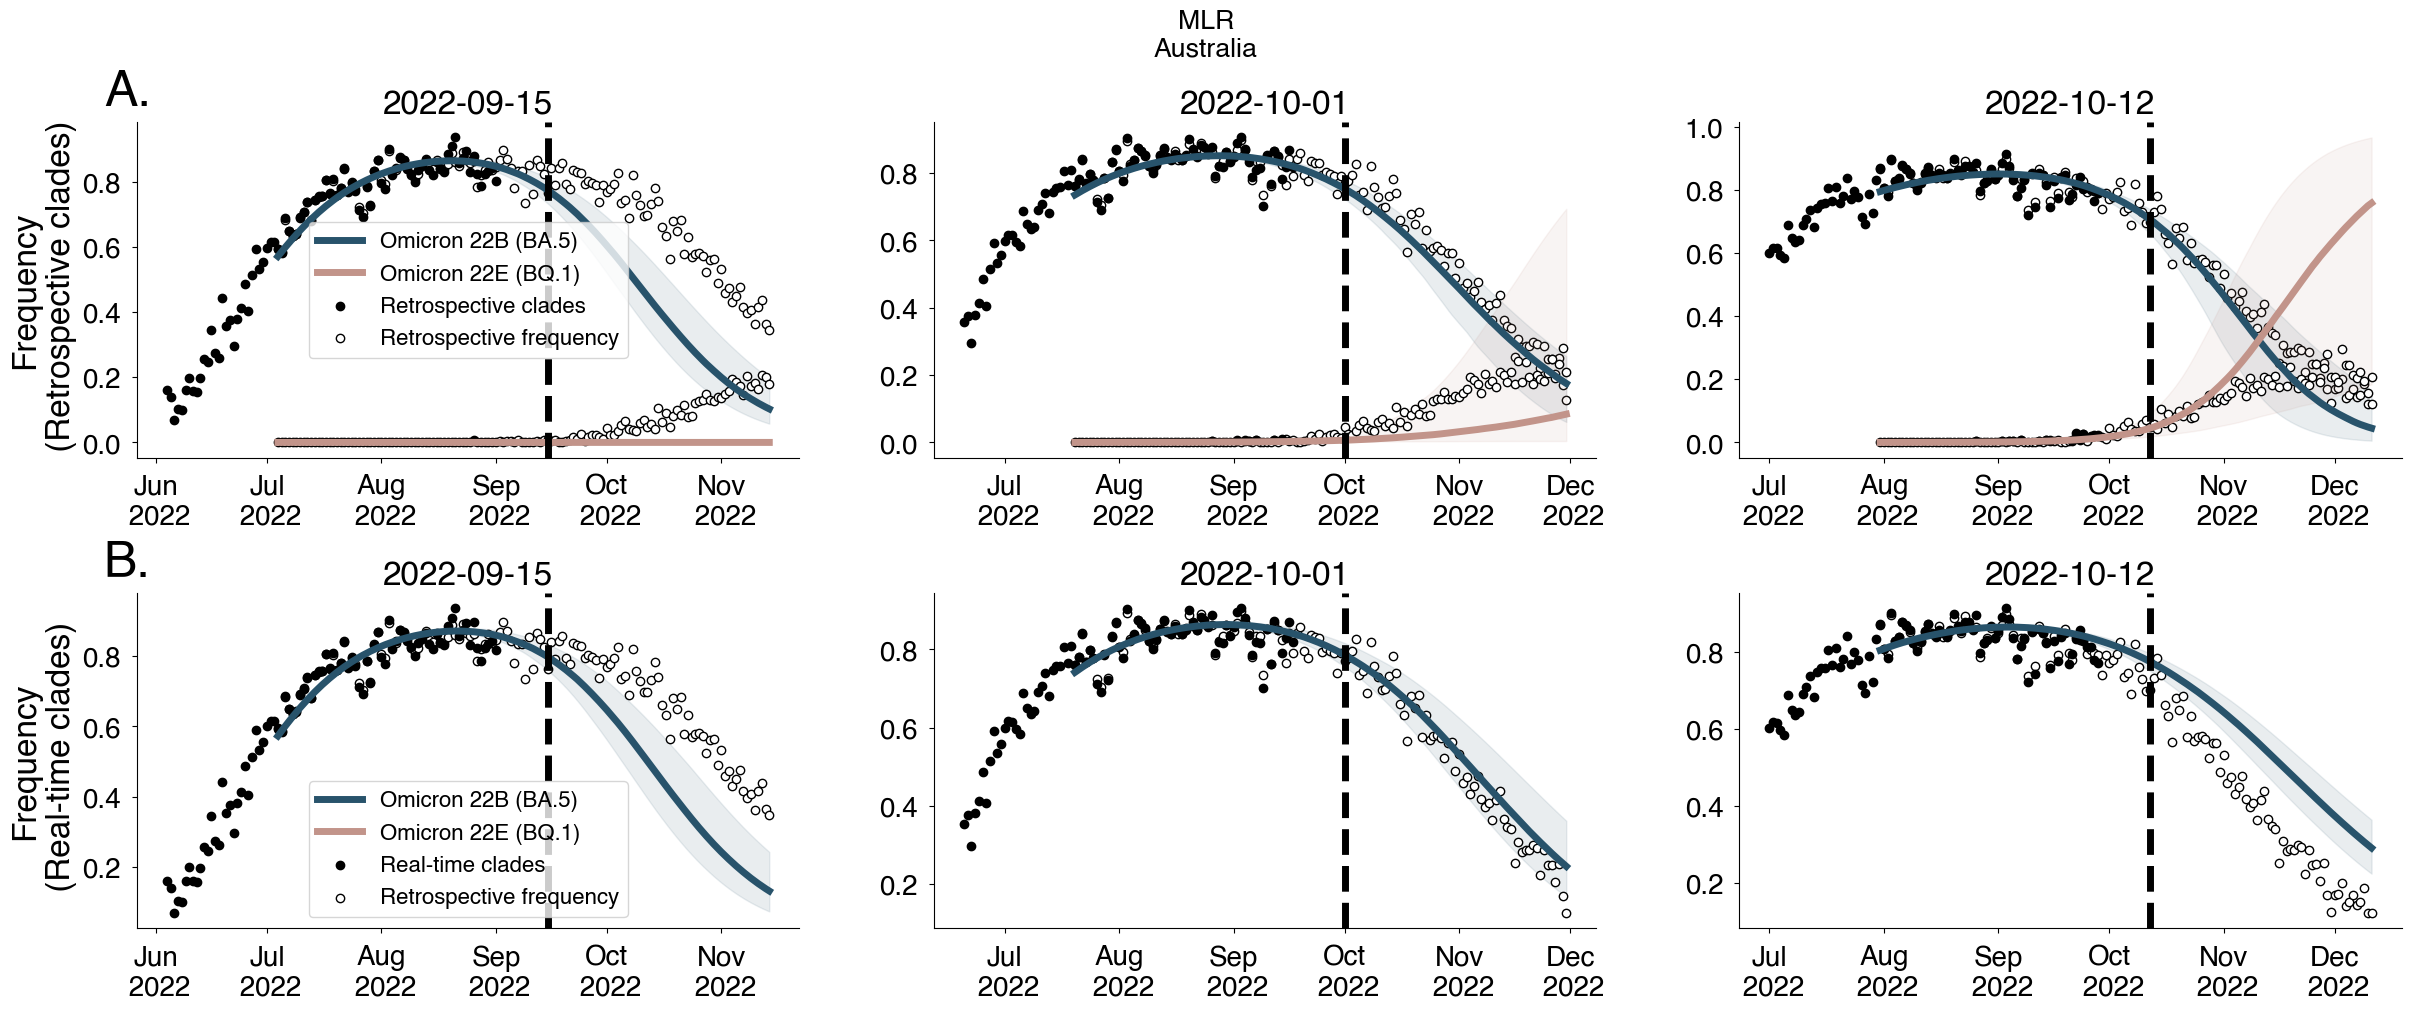

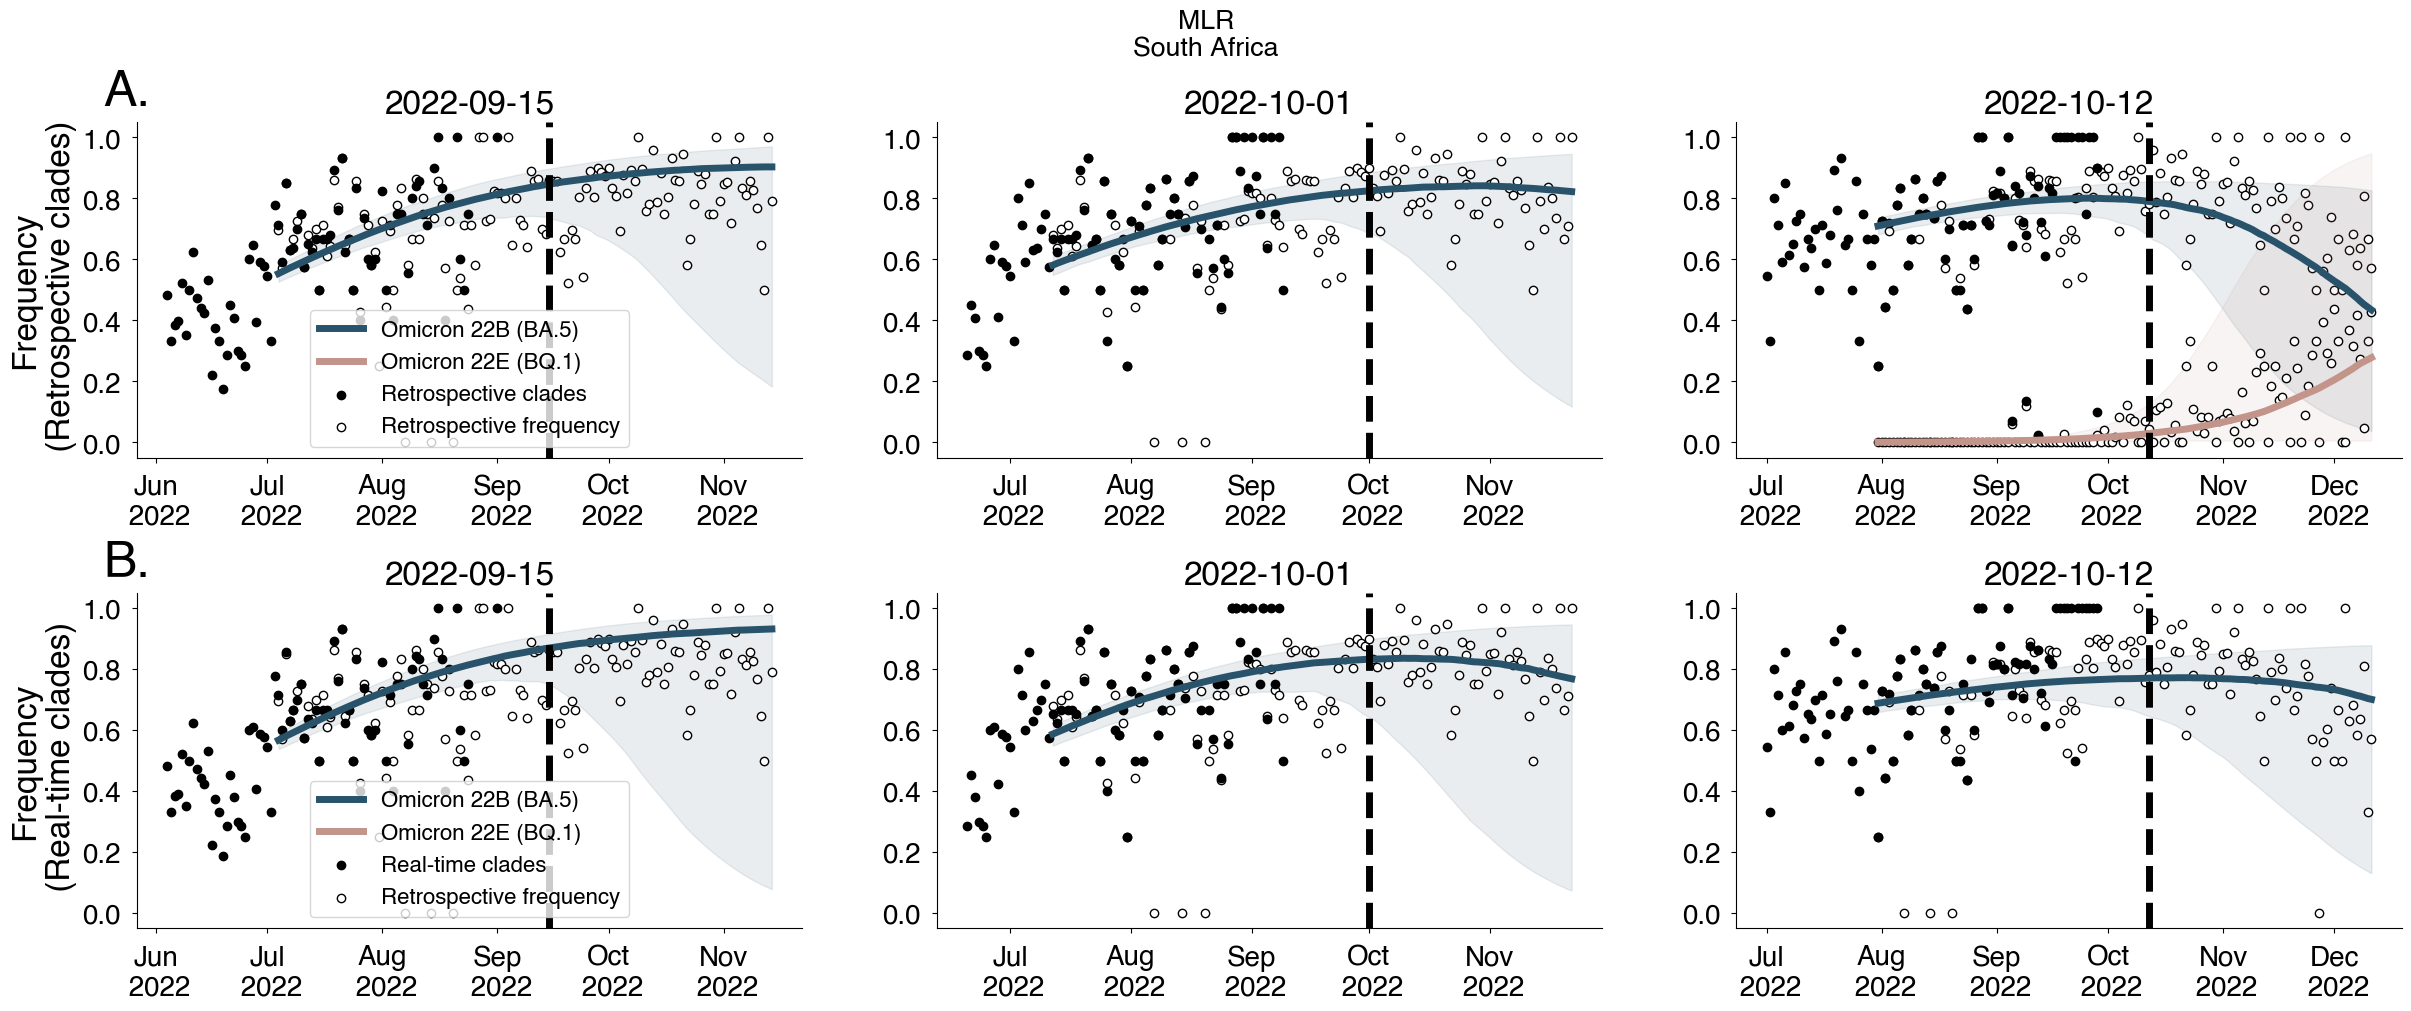

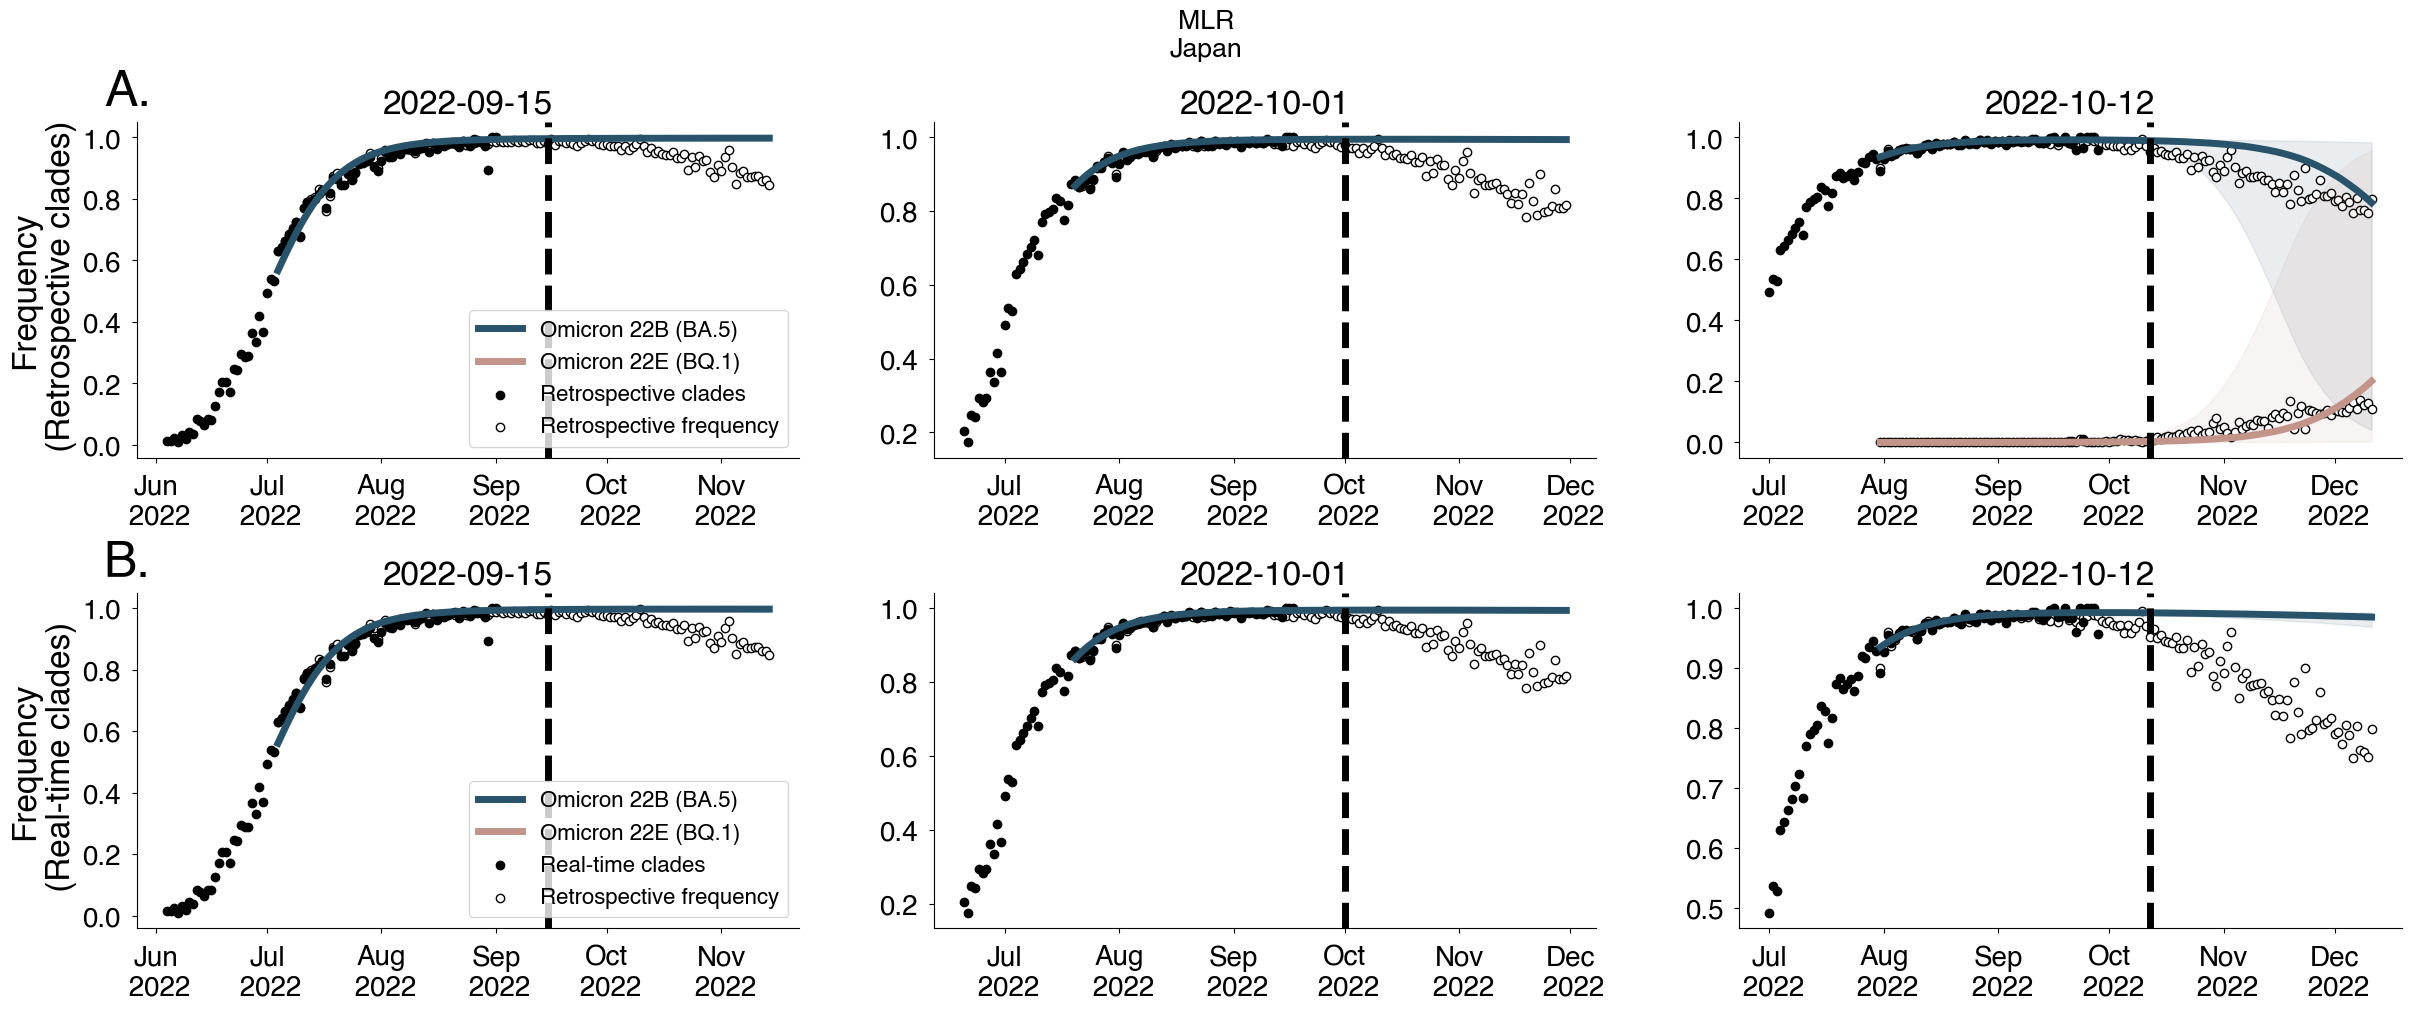

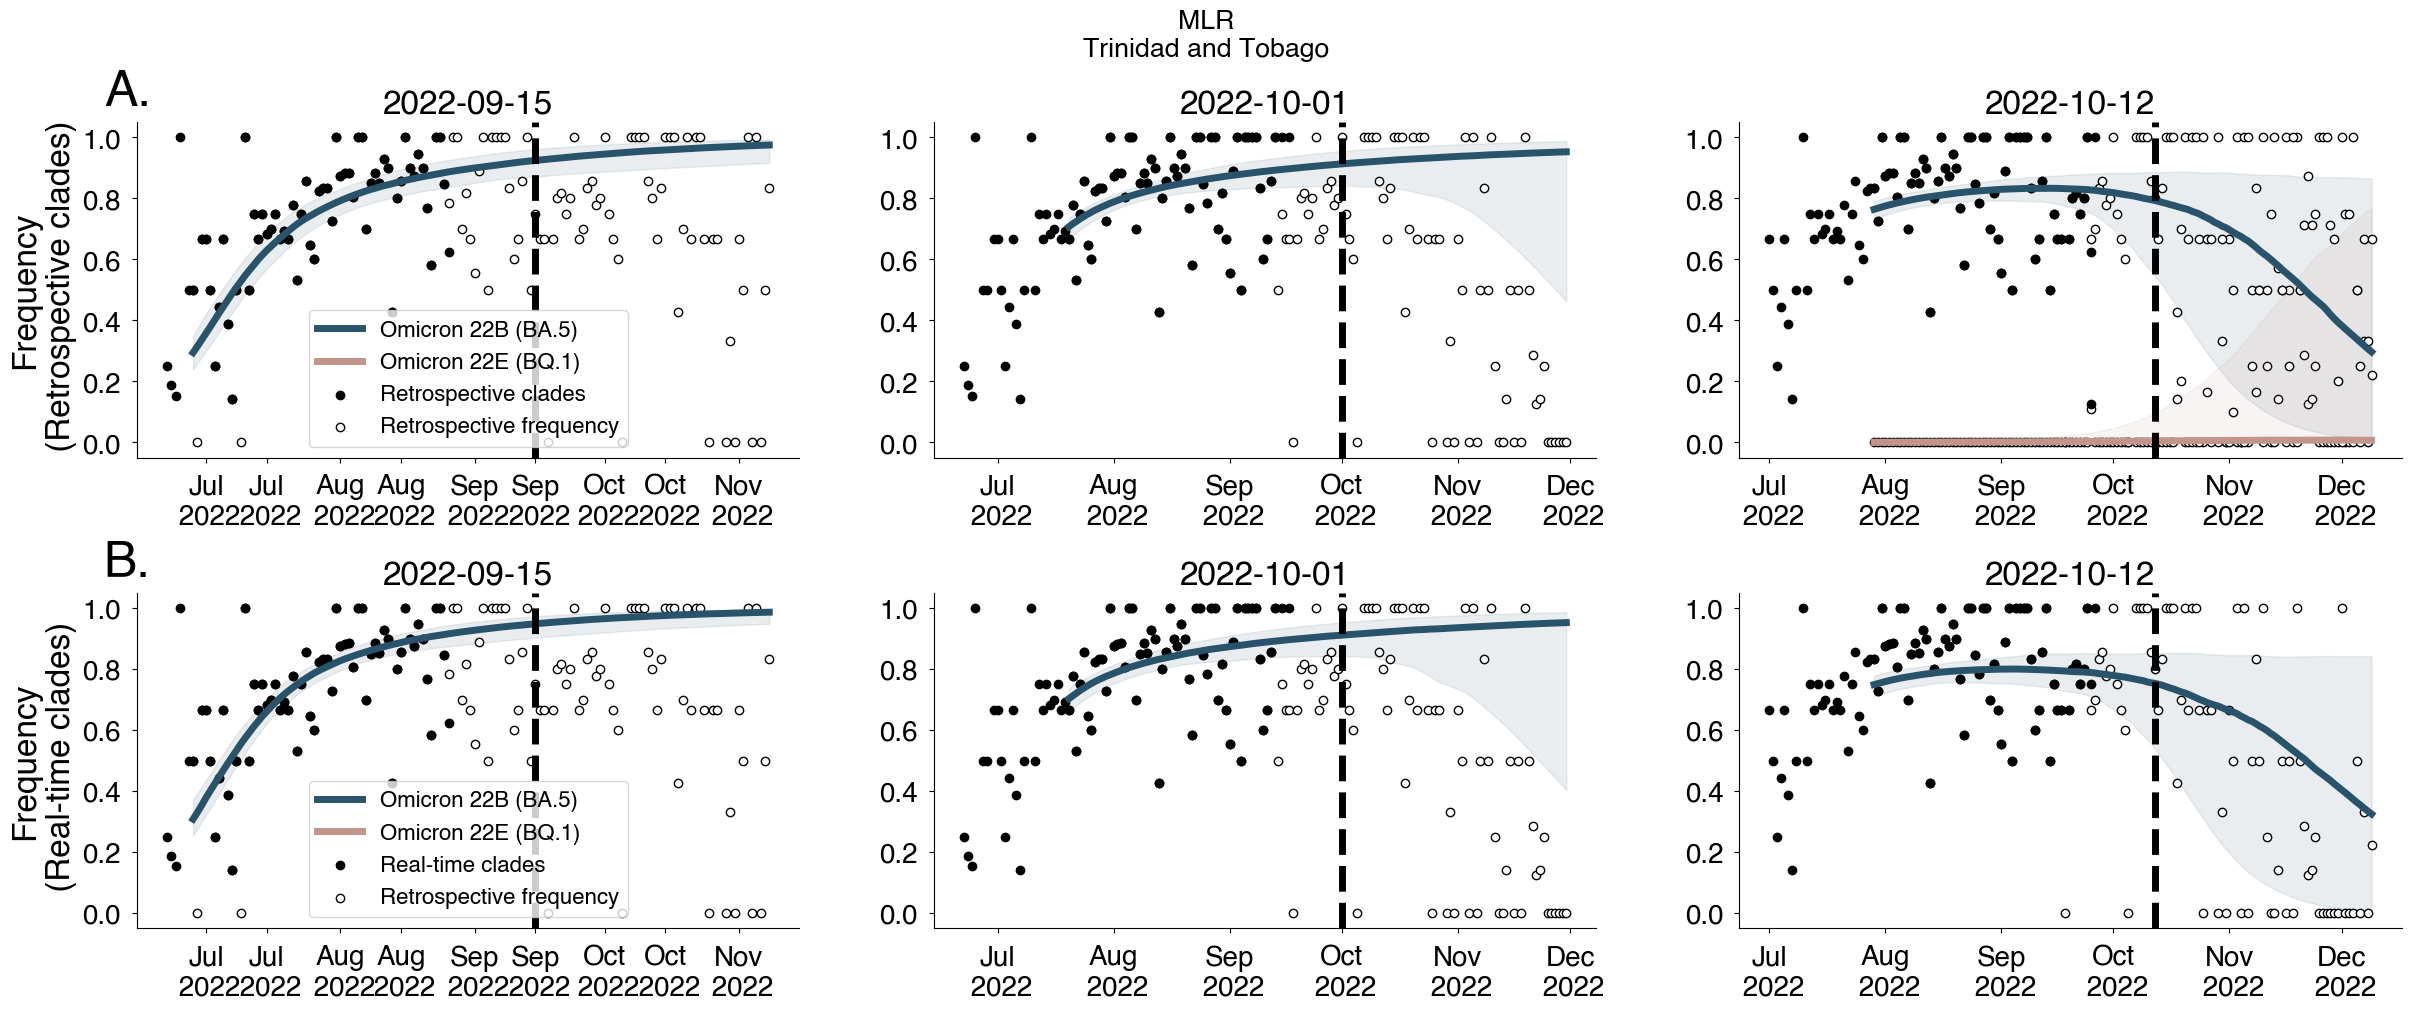

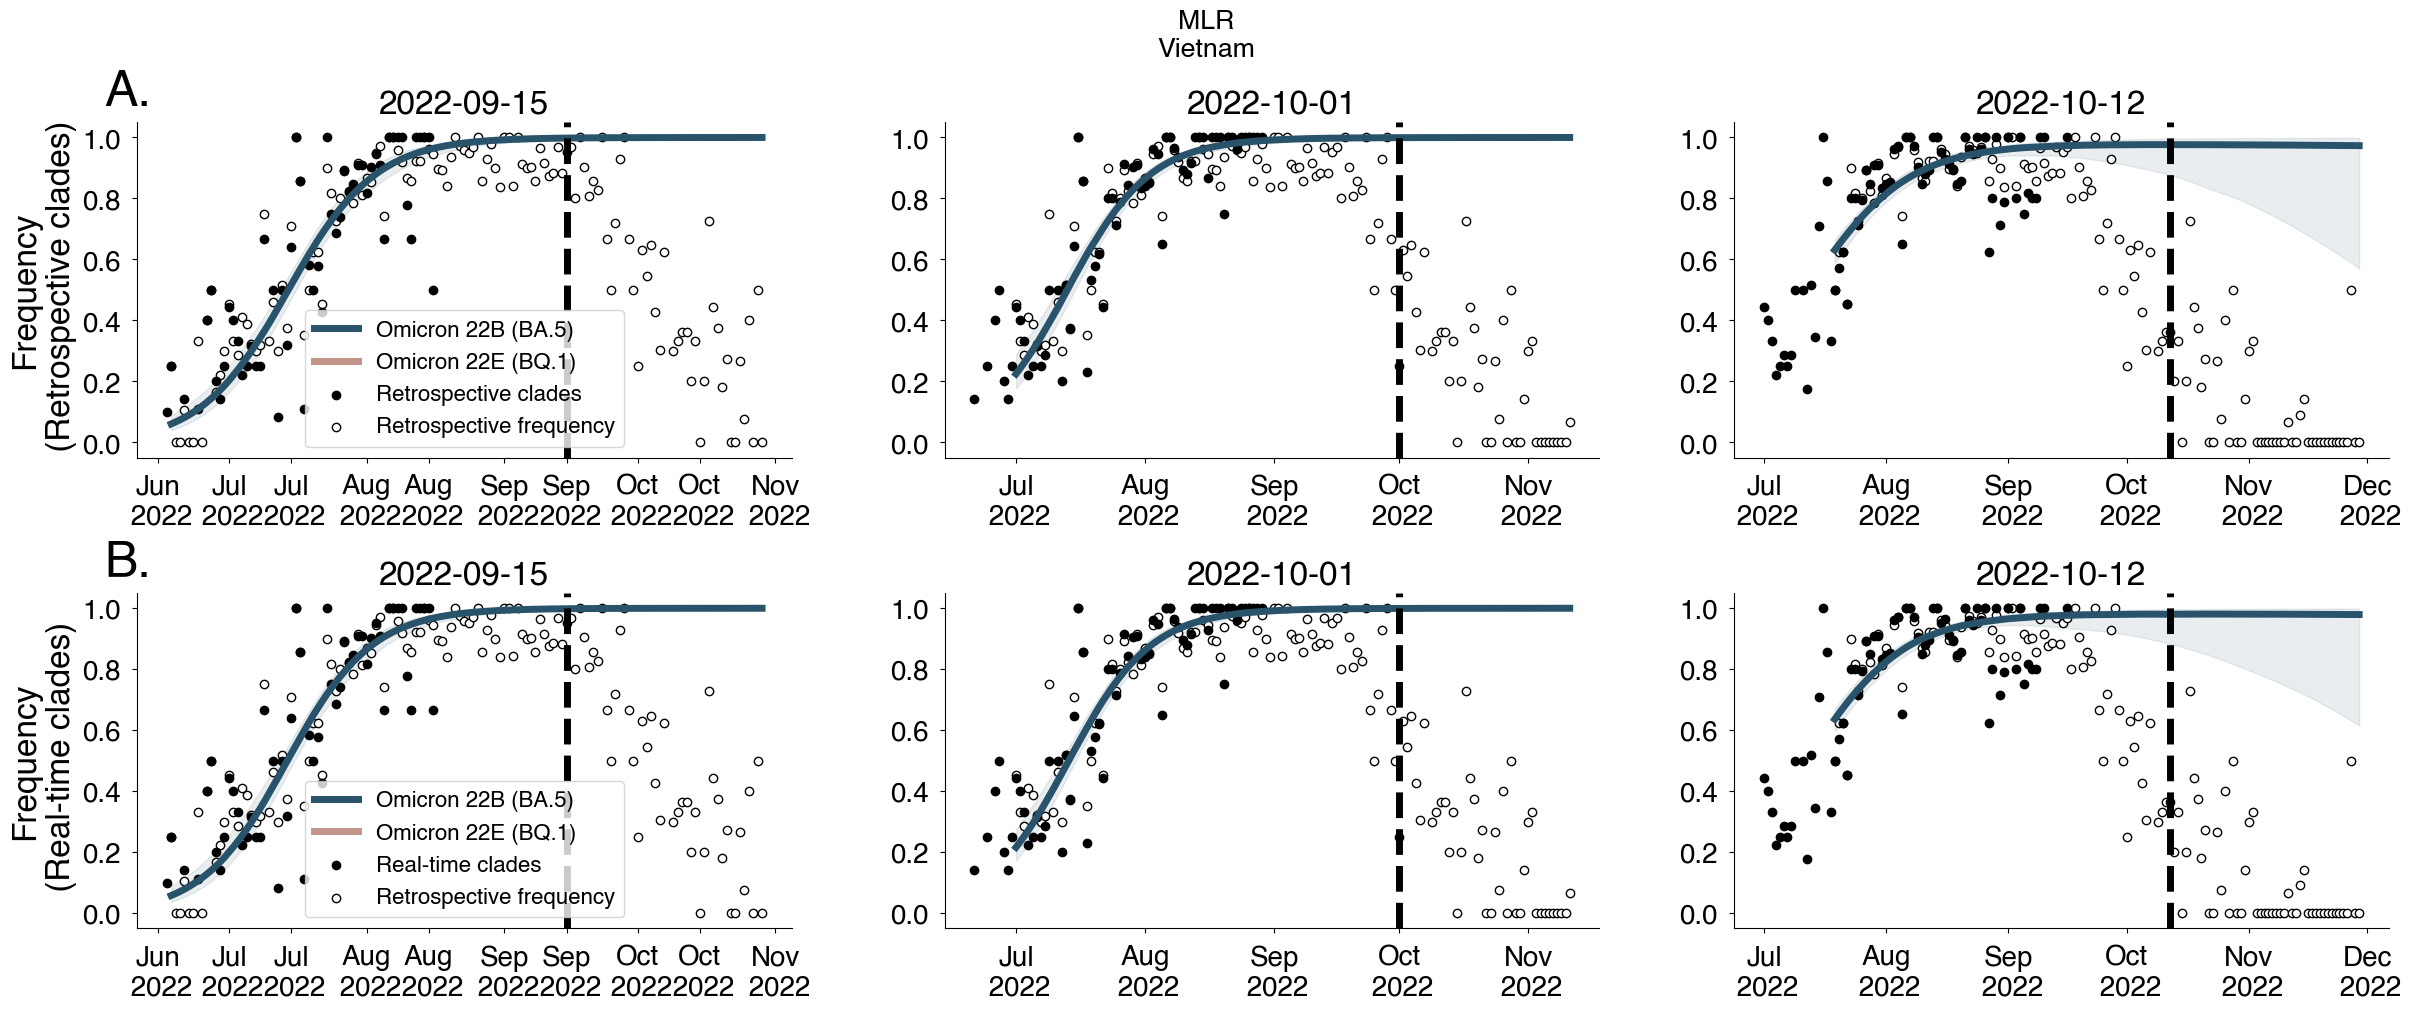

In [14]:
plots_loc = {}
for location in errors.location.unique():
    plots_loc[location] = make_nextclade_comparison_plot(variants, location, model)

In [15]:
for location in errors.location.unique():
    clean_location = location.replace(" ", "_")
    plots_loc[location].savefig(f"../manuscript/supp_figures/forecast-comparison-by-nextclade-version-{clean_location}.png")

In [8]:
mean_mae = (errors
    .groupby(["location", "nextclade_version", "lead"])
    .agg({'MAE':['mean','sem']})
    .reset_index()
)

mean_mae.columns = ['location', 'nextclade_version', 'lead', 'MAE_mean', 'MAE_sem']
mean_mae

location nextclade_version  lead  MAE_mean   MAE_sem
0     Australia         real_time   -73  0.010009  0.002307
1     Australia         real_time   -72  0.008641  0.001956
2     Australia         real_time   -71  0.008125  0.001656
3     Australia         real_time   -70  0.006862  0.001439
4     Australia         real_time   -69  0.005960  0.001382
...         ...               ...   ...       ...       ...
2235    Vietnam     retrospective    56  0.209234  0.073606
2236    Vietnam     retrospective    57  0.210876  0.074568
2237    Vietnam     retrospective    58  0.209322  0.074269
2238    Vietnam     retrospective    59  0.209259  0.074623
2239    Vietnam     retrospective    60  0.209161  0.074058

[2240 rows x 5 columns]

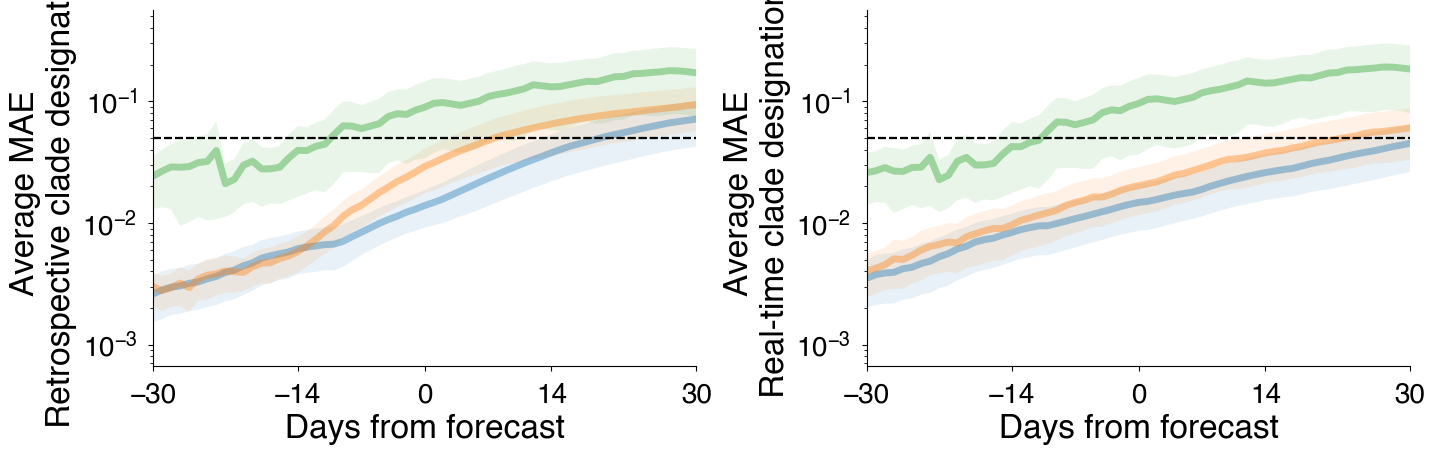

In [9]:
# Plot MAE over lead for each data set
fig = plt.figure(figsize=(36., 8.), constrained_layout=True)
spec = fig.add_gridspec(ncols=6, nrows=2)

def plot_error_by_version(ax, mean_mae, nextclade_version, location, ylabel=None, desired_thres=0.05):
    _mean_mae = mean_mae.copy()
    _mean_mae = _mean_mae[_mean_mae.nextclade_version == nextclade_version]

    _mean_mae = _mean_mae[_mean_mae.location == location]

    ax.plot(_mean_mae.lead, _mean_mae.MAE_mean, alpha=0.4)
    ax.fill_between(_mean_mae.lead, 
                    _mean_mae.MAE_mean - 2*_mean_mae.MAE_sem, 
                    _mean_mae.MAE_mean + 2*_mean_mae.MAE_sem,
                    alpha=0.1)

    ax.set_xlabel("Days from forecast")
    ax.set_ylabel(ylabel)
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)

for n, nextclade_version in enumerate(["retrospective", "real_time"]):
    ax = fig.add_subplot(spec[n])
    
    if n == 0:
        ax0 = ax
    else:
        ax.sharey(ax0)
        
    for loc in ["USA", "United Kingdom", "Vietnam"]:
        plot_error_by_version(ax, mean_mae, nextclade_version, location=loc, ylabel=f"Average MAE \n {NC_VERSION_TO_LABEL[nextclade_version]}")

    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres
    ax.set_yscale("log", base=10)

/var/folders/27/fy80dyf90h520912n_x6g8nm0000gn/T/ipykernel_7690/3343992704.py:46: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


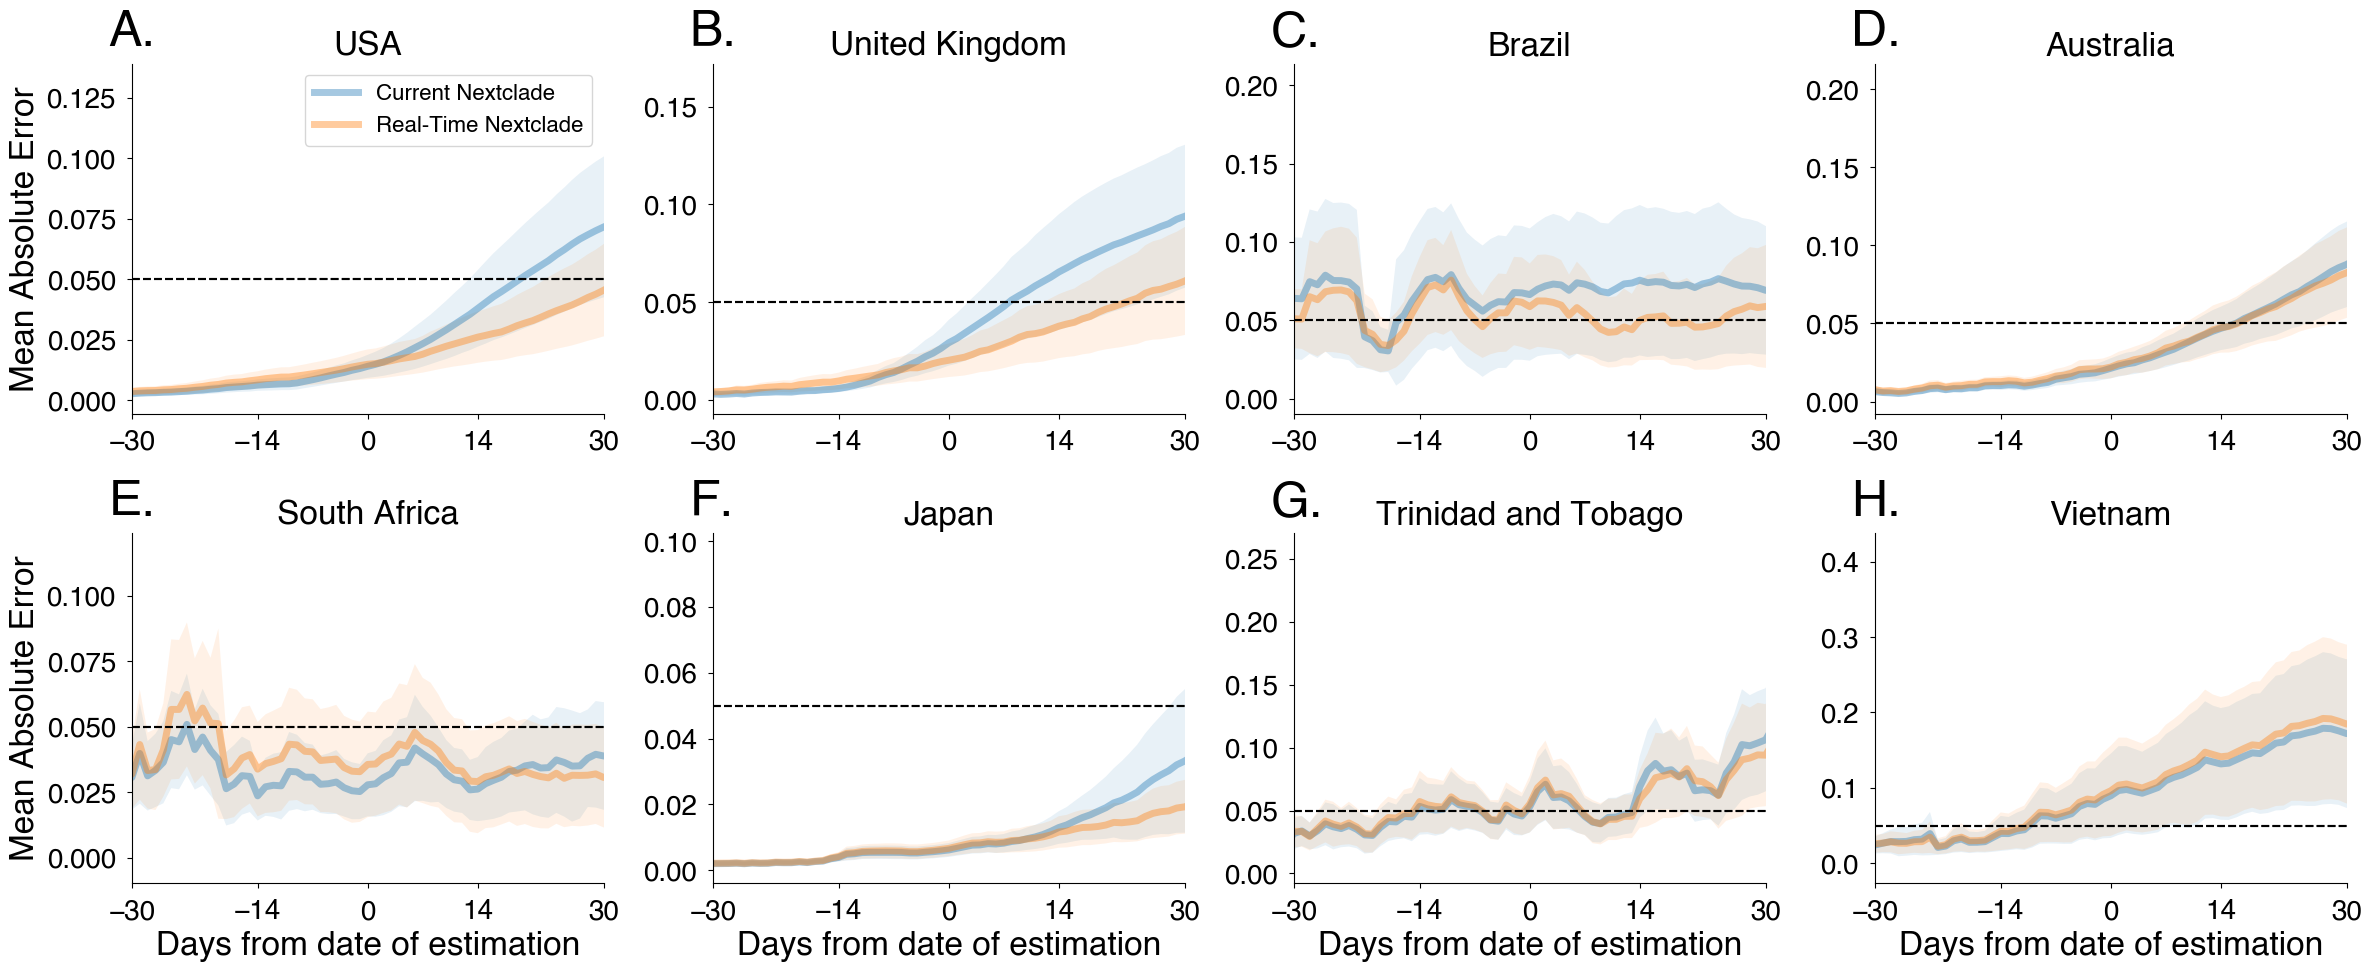

In [102]:
# Really want to compare for each country

# Plot MAE over lead for each data set
fig = plt.figure(figsize=(24., 10.), constrained_layout=True)
spec = fig.add_gridspec(ncols=4, nrows=2)

def plot_error_by_version(ax, mean_mae, nextclade_version, location, ylabel=None, xlabel="Days from forecast", desired_thres=0.05):
    _mean_mae = mean_mae.copy()
    _mean_mae = _mean_mae[_mean_mae.nextclade_version == nextclade_version]

    _mean_mae = _mean_mae[_mean_mae.location == location]

    ax.plot(_mean_mae.lead, _mean_mae.MAE_mean, alpha=0.4, label=NC_VERSION_TO_LABEL[nextclade_version])
    ax.fill_between(_mean_mae.lead, 
                    _mean_mae.MAE_mean - 2*_mean_mae.MAE_sem, 
                    _mean_mae.MAE_mean + 2*_mean_mae.MAE_sem,
                    alpha=0.1)

    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.axhline(y=desired_thres, color="k", linestyle="--", linewidth=1.5)
    return None

axes_to_label = []
for l, loc in enumerate(errors.location.unique()):
    ax = fig.add_subplot(spec[l])

    for nextclade_version in ["retrospective", "real_time"]:
        ylabel = "Mean Absolute Error" if l % 4 == 0 else ""
        xlabel = "Days from date of estimation" if l > 3 else ""
        plot_error_by_version(ax, mean_mae, nextclade_version, location=loc, ylabel=ylabel,xlabel=xlabel)

    ax.set_xlim((-30,30))
    ax.set_xticks([-30, -14, 0, 14, 30]) # Can find first point you cross accuracy threshold @ each sequencing thres
    
    #ax.set_yscale("log", base=10)
    ax.set_title(loc)
    axes_to_label.append(ax)
    if l == 0:
        ax.legend()
        
ax_labels = [s + "." for s in string.ascii_uppercase]
for ax, ax_label in zip(axes_to_label, ax_labels):
    ax.text(-0.05, 1.05, ax_label, transform=ax.transAxes, size=36, weight='bold')

fig.tight_layout()

fig.savefig("../manuscript/supp_figures/mean_absolute_error_at_lead_nextclade_version_comparison.png")